# Evaluation of trained network for temporal super-resolution

In [ ]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display
from utils.evaluate_utils import *
plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

### Set model and dataset to evaluate


In [ ]:
# Define directories and filenames
# model_name = '20230210-0333' #
# set_name = 'Test'
# data_model= '3'

# model_name = '20230215-1029' 
# set_name = 'Training'
# data_model= '1'

# model_name = '20230217-0602'    
# set_name = 'Test'               
# data_model= '4'
# step = 2

model_name = '20230301-1641'    
set_name = 'Test'               
data_model= '4'
step = 2

### Set evaluation files to compare relative error to


In [ ]:
vel_colnames=['u', 'v', 'w']
vel_colnames_fluid = ['u_fluid', 'v_fluid', 'w_fluid']

def load_data(model_name, set_name, data_model, step):
    #directories
    gt_dir = '../data/CARDIAC'
    result_dir = f'../results/Temporal4DFlowNet_{model_name}'
    eval_dir = f'{result_dir}/plots'
    lr_dir = '../data/CARDIAC'

    #filenames
    gt_filename = f'M{data_model}_2mm_step{step}_static.h5'
    lr_filename = f'M{data_model}_2mm_step{step}_static_noise.h5'
    result_filename = f'{set_name}set_result_model{data_model}_2mm_step{step}_{model_name[-4::]}_temporal.h5' #_newpadding
    evaluation_filename = f'eval_rel_err_{data_model}_2mm_step{step}_{model_name[-4::]}_temporal.h5'


    if not os.path.isdir(eval_dir):
        os.makedirs(eval_dir)

    #Params for evalation
    save_relative_error_file= False

    # Setting up
    gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
    res_filepath = '{}/{}'.format(result_dir, result_filename)
    lr_filepath = '{}/{}'.format(lr_dir, lr_filename)


    if save_relative_error_file:
        assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

    
    gt = {}
    lr = {}
    pred = {}

    with h5py.File(res_filepath, mode = 'r' ) as h_pred:
        with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
            with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
                
                gt["mask"] = np.asarray(h_gt["mask"])
                gt["mask"][np.where(gt["mask"] !=0)] = 1
                temporal_mask = create_temporal_mask(gt["mask"], h_gt['u'].shape[0])
                # adapt dimension
                for vel in vel_colnames:
                    
                    gt[vel] = np.asarray(h_gt[vel])
                    pred[vel] = np.asarray(h_pred[f'{vel}_combined'])   # TODO chnaged this with new combination of all axis 
                    lr[vel] = np.asarray(h_lr[vel])[::2, :, :, :]       #TODO: this chnaged with the new loading modules
                    #transpose for temporal resolution
                    # pred[vel] = pred[vel].transpose(1, 0, 2, 3) #TODO changed for new csv file
                    # print(pred[vel].shape)

                    # add information considering only the fluid regions  
                    pred[f'{vel}_fluid'] =np.multiply(pred[vel], temporal_mask)
                    lr[f'{vel}_fluid'] =  np.multiply(lr[vel], temporal_mask[::2, :, :, :])
                    gt[f'{vel}_fluid'] =  np.multiply(gt[vel], temporal_mask)

                    
                #include speed calculations
                gt['speed']   = np.sqrt(gt["u"]**2 + gt["v"]**2 + gt["w"]**2)
                lr['speed']   = np.sqrt(lr["u"]**2 + lr["v"]**2 + lr["w"]**2)
                pred['speed'] = np.sqrt(pred["u"]**2 + pred["v"]**2 + pred["w"]**2)



    return lr, gt, pred, temporal_mask, eval_dir
lr, gt, pred, temporal_mask, eval_dir = load_data(model_name, set_name, data_model, step)

In [ ]:

plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = 'u')
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = 'v')
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = 'w')
plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('frame')
plt.title('RMSE')

### Create interpolation data from low resolution data

In [ ]:
#this can take a while
interpolate_NN = {}
interpolate_linear = {}
interpolate_cubic = {}

vel_colnames=['u', 'v', 'w']

for vel in vel_colnames:
    print("Interpolate low resolution images - ", vel)
    
    interpolate_linear[vel] = temporal_linear_interpolation(lr[vel], gt[vel].shape)
    interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])

    interpolate_cubic[vel] = temporal_cubic_interpolation(lr[vel], gt[vel].shape)
    interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])

    interpolate_NN[vel] = temporal_NN_interpolation(lr[vel], gt[vel].shape)
    interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])


### Calculate relative error and mean speed

In [ ]:
rel_error =calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
error_pointwise, error_absolut = calculate_pointwise_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

for vel in vel_colnames:
    error_absolut[f'{vel}_fluid'] = np.multiply(error_absolut[vel], gt["mask"])

# mean speed of gt and prediction
gt['mean_speed'] = calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])
pred['mean_speed'] = calculate_mean_speed(pred["u_fluid"], pred["v_fluid"] , pred["w_fluid"], gt["mask"])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], gt["mask"])
interpolate_cubic['mean_speed'] = calculate_mean_speed(interpolate_cubic["u_fluid"], interpolate_cubic["v_fluid"] , interpolate_cubic["w_fluid"], gt["mask"])

#### Compare different axis predicrrion with averaged prediction


In [ ]:
# pred_axis0 = {}
# pred_axis1 = {}
# pred_axis2 = {}
# vel_colnames=['u', 'v', 'w']
# #Compare the combined and not combined evaulations
# with h5py.File(res_filepath, mode = 'r' ) as h_pred:
#     for vel in vel_colnames:
#         pred_axis0[vel] = np.asarray(h_pred[f'{vel}_axis0'])   
#         pred_axis1[vel] = np.asarray(h_pred[f'{vel}_axis1'])  
#         pred_axis2[vel] = np.asarray(h_pred[f'{vel}_axis2'])  

#         pred_axis0[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis0[vel])
#         pred_axis1[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis1[vel])
#         pred_axis2[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis2[vel])

# rel_error_axis0 = calculate_relative_error_normalized(pred_axis0["u"], pred_axis0["v"], pred_axis0["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# rel_error_axis1 = calculate_relative_error_normalized(pred_axis1["u"], pred_axis1["v"], pred_axis1["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# rel_error_axis2 = calculate_relative_error_normalized(pred_axis2["u"], pred_axis2["v"], pred_axis2["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# mean_speed_axis0 = calculate_mean_speed(pred_axis0["u_fluid"], pred_axis0["v_fluid"] , pred_axis0["w_fluid"], gt["mask"])
# mean_speed_axis1 = calculate_mean_speed(pred_axis1["u_fluid"], pred_axis1["v_fluid"] , pred_axis1["w_fluid"], gt["mask"])
# mean_speed_axis2 = calculate_mean_speed(pred_axis2["u_fluid"], pred_axis2["v_fluid"] , pred_axis2["w_fluid"], gt["mask"])



# plt.subplot(2, 1, 1)
# #plot_relative_error([gt_filepath],[res_filepath], [set_name])

# #plt.legend(lst_names)
# plt.title("Relative error")
# plt.plot(rel_error, label = 'averaged prediction')
# # plt.plot(rel_error_axis0, label = "axis 0")
# # plt.plot(rel_error_axis1, label = "axis 1")
# # plt.plot(rel_error_axis2, label = "axis 2")
# plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
# plt.plot(50*np.ones(len(rel_error)), 'k:')
# plt.xlabel("Frame")
# plt.ylabel("Relative error (%)")
# plt.ylim((0, 100))
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
# plt.plot(pred['mean_speed'],'b', label= set_name, color = 'steelblue')
# # plt.plot(mean_speed_axis0, label = "axis 0")
# # plt.plot(mean_speed_axis1, label = "axis 1")
# # plt.plot(mean_speed_axis2, label = "axis 2")
# plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolation', color = 'yellowgreen')
# # plt.plot(mean_speed_cubic_interpolation[:-1], label = 'cubic interpoaltion', color = 'forestgreen')
# plt.xlabel("Frame")
# plt.ylabel("Mean speed (cm/s)")
# plt.legend()

# plt.savefig(f'{eval_dir}/Erl_error_{set_name}.svg')
# plt.show()



## Show results including non-fluid region
 

In [ ]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)



@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 10, vel = "u"):
    plt.subplot(1, 5, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("LR")
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(interpolate_linear[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("Linear Interpolation")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(interpolate_cubic[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("Cubic Interpolation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



## Show results with only fluid region

In [ ]:


@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames_fluid, patch_size=(10, 30))
def f(frame=5, x = 10, vel = "u", patch_size=20):
    N = 7
    mid_y = gt["u"].shape[2]//2
    mid_z = gt["u"].shape[3]//2

    plt.subplot(1, N, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]), vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(gt[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size], vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')#, origin = 'lower')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(pred[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow(interpolate_linear[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Linear")
    plt.axis('off')

    plt.subplot(1, N, 5)
    plt.imshow(interpolate_cubic[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Cubic")
    plt.axis('off')

    plt.subplot(1, N, 6)
    plt.imshow(error_pointwise[frame, x,mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size], cmap='viridis')
    plt.title("Relative error")
    plt.axis('off')

    plt.subplot(1, N, 7)
    plt.imshow(error_absolut[vel][frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size], cmap='viridis')
    plt.title("Absolute error")
    plt.axis('off')

    plt.tight_layout()
    #plt.colorbar()
    plt.show()

In [ ]:
compare_velocitywise = False


if compare_velocitywise:

    plt.subplot(2,1, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u')
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v')
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(2,1, 2)
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.show()

else:
    plt.subplot(1, 3, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'u')
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u predicted')    
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = 'v')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v predicted')
    plt.xlim(np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.legend()
    plt.xlabel('value')

    plt.subplot(1, 3, 3)
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = 'w')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w predicted')
    plt.xlim(np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot relative error and mean speed 

In [ ]:
plt.subplot(2, 1, 1)
#plot_relative_error([gt_filepath],[res_filepath], [set_name])

#plt.legend(lst_names)
plt.title("Relative error")
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()
mean_error = np.mean(error_pointwise, axis=(1, 2, 3))
sd_error = np.std(error_pointwise, axis = (1, 2, 3))

error = np.random.normal(mean_error, sd_error, size=len(rel_error))
y =  rel_error +error #np.random.normal(0, 0.1, size=y.shape)

#plt.plot(x, y, 'k-')
plt.fill_between(range(len(rel_error)), y-error, y+error)

plt.subplot(2, 1, 2)
plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
plt.plot(pred['mean_speed'],'b', label= set_name, color = 'steelblue')
plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolatiom', color = 'yellowgreen')
plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend()
plt.show()
#lst_hgt_paths, lst_hpred_paths,lst_names, save_as = 'Relative_error_comparison.png'

In [ ]:
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()
points_in_mask = np.where(gt['mask'] !=0)

reshaped_error = np.tanh(error_pointwise[:, points_in_mask[0], points_in_mask[1], points_in_mask[2]].reshape(frames, -1))
max_error = np.max(reshaped_error, axis=1)*100

sd_error = np.std(reshaped_error, axis = 1)*100
error = np.random.normal(0, sd_error, size=len(rel_error))
plt.fill_between(range(len(rel_error)), rel_error-sd_error, rel_error+sd_error, alpha = 0.5)
#plt.fill_between(range(len(rel_error)), rel_error-max_error, rel_error+max_error, alpha = 0.5)

### Quiver plot testing

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

set_to_zero = 0.8
x_idx, y_idx, z_idx = random_indices3D(gt['mask'], int(np.count_nonzero(gt['mask'])*set_to_zero))
x_len, y_len, z_len = gt['u'].shape[1::]


@widgets.interact(frame=(0, gt["u"].shape[0]-1))
def f_quiver(frame=10 ):
    #frame = 15
    u_quiver = gt['u'][frame].copy()
    v_quiver = gt['v'][frame].copy()
    w_quiver = gt['w'][frame].copy()

    # ev = np.array([1, 0, 0])
    #angles = np.arccos(np.dot(ev, [u, v, w]) / (np.linalg.norm(ev) * np.linalg.norm(v2)))
    # angles = np.multiply
    # Make the grid
    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    u_quiver[x_idx, y_idx, z_idx] = 0
    v_quiver[x_idx, y_idx, z_idx] = 0
    w_quiver[x_idx, y_idx, z_idx] = 0

    cropx = cropy = cropz = 50
    startx = x_len//2-(cropx//2)
    starty = y_len//2-(cropy//2)    
    startz = z_len//2-(cropz//2)
    u_quiver = u_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    v_quiver = v_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    w_quiver = w_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 

    x =x[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    y =y[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    z =z[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz]

    u_new = u_quiver[np.where(u_quiver != 0)]
    v_new = v_quiver[np.where(u_quiver != 0)]
    w_new = w_quiver[np.where(u_quiver != 0)]

    x_new = x[np.where(u_quiver!=0)] 
    y_new = y[np.where(u_quiver!=0)] 
    z_new = z[np.where(u_quiver!=0)]


    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.magma(c)


    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    plt.show()

In [ ]:
def create_temporal_comparison_gif_plt(idx, lr, hr, pred, vel):
    N = 4
    v_lr = lr[vel]
    v_hr = hr[vel]
    v_pred = pred[vel]
    v_error_abs= error_absolut[f'{vel}_fluid']
    v_NN = temporal_NN_interpolation(v_lr,v_hr.shape )

    err_max = np.quantile(v_error_abs[np.where(temporal_mask !=0)].flatten(), 0.999)

    fig = plt.figure(frameon=False)
    plt.subplot(1, N, 1)
    im1 = plt.imshow(v_NN[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 2)
    im2 = plt.imshow(v_hr[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 3)
    im3 = plt.imshow(v_pred[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')

    plt.subplot(1, N, 4)
    im4 = plt.imshow(v_pred[0, idx, :, :],vmin=0, vmax=err_max)
    plt.axis('off')
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()


    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        im2.set_data(np.random.random((5,5)))
        im3.set_data(np.random.random((5,5)))
        im4.set_data(np.random.random((5,5)))
        return [im1, im2, im3]

    # animation function.  This is called sequentially
    def animate(i):
        
        im1.set_array(v_NN[i, idx, :, :])
        im2.set_array(v_hr[i, idx, :, :])
        im3.set_array(v_pred[i, idx, :, :])
        im4.set_array(v_error_abs[i, idx, :, :])
        
        return [im1, im2, im3]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/Animate_{vel}_fluid.gif', fps=300)

def create_temporal_comparison_gif_single(idx, data, vel, title):

    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    # im1 = plt.imshow(data[0, idx, :, :],interpolation='none', vmin=min_v[vel], vmax=max_v[vel])
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, idx, :, :])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/Animate_{title}_{vel}.gif', fps=300)

    #generate_gif_volume(combined_image[:,idx, :, : ], axis = 0, save_as = save_as)

create_temporal_comparison_gif_plt(22, lr, gt, pred, "u")
create_temporal_comparison_gif_plt(22, lr, gt, pred, "v")
create_temporal_comparison_gif_plt(22, lr, gt, pred, "w")
#create_temporal_comparison_gif_plt(22, lr, gt, pred, "speed")
# velo = 'u'
# create_temporal_comparison_gif_single(22, temporal_NN_interpolation(lr[velo],gt[velo].shape), velo, "LR")
# create_temporal_comparison_gif_single(22, gt[velo],velo , "HR")
# create_temporal_comparison_gif_single(22, pred[velo],velo, "4DFlowNet")
# create_temporal_comparison_gif_single(22, error_absolut[velo], velo, "Absolute Error")
# First set up the figure, the axis, and the plot element we want to animate


### Plot regression lines

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1))
def f_regression(frame=10 ):
    plot_regression(gt, pred, frame_idx=frame)
    plt.tight_layout()
    plt.show()

### Plot line development in time

In [ ]:
vel_colnames=['u_fluid', 'v_fluid', 'w_fluid']
#def show_temporal_development_line(gt, lr, pred, mask, axis, indices, save_as = "Temporal_development.png"):
@widgets.interact(x=(0, gt["u"].shape[1]-1), y = (0, gt["u"].shape[2]-1), vel=vel_colnames, axis=(1, 3))
def f_temporal_development_lines(x = 30,y =40, vel = "u", axis =1):

        indices = (x, y)
        def get_line(data):
            #returns line in 4D data over all time steps
            x,y = indices
            if axis == 1:
                return data[:, :, x, y]
            elif axis ==2:
                return data[:, x, :, y]
            elif axis ==3:
                return data[:, x,  y, :]
            else:
                print("Invalid axis: Please choose axis 1, 2, 3")

        prediction = get_line(pred[vel]).transpose()
        ground_truth = get_line(gt[vel]).transpose()
        low_resolution= get_line(interpolate_NN[vel]).transpose()

        min_v = np.min([np.min(prediction), np.min(ground_truth), np.min(low_resolution)])
        max_v = np.max([np.max(prediction), np.max(ground_truth), np.max(low_resolution)])


        plt.subplot(1, 3, 1)
        plt.imshow(low_resolution, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("LR")
        plt.xlabel('t')
        plt.yticks([])

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("GT")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 3, 3)
        plt.imshow(prediction, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("SR")
        plt.xticks([])
        plt.yticks([])

### Plot peak flow development

In [ ]:
#Params for plot
patch_size = 1
show_avg = False
show_pixel = True


idx_max = np.unravel_index(np.argmax(gt['speed']), shape = gt['speed'].shape)
x = np.arange(gt['speed'].shape[0])
if show_pixel:
    plt.plot(x, gt['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,  label = 'ground truth pixel', color = 'black')
    plt.plot(x[::2], lr['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'-o' ,label = 'low resolution pixel')
    plt.plot(x, pred['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'--', label = 'prediction pixel')

if show_avg:
    plt.plot(x,         np.average(gt['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,  label = 'ground truth avg', color = 'black')
    plt.plot(x[::2],    np.average(lr['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'-o' ,label = 'low resolution avg')
    plt.plot(x,         np.average(pred['speed'][:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'--', label = 'prediction avg')
plt.title(f"Speed at pixel {idx_max[1::]} with average of number of voxels: {(2*patch_size+1)**3}")
plt.ylabel('Speed (cm/s)')
plt.xlabel('Frame')
plt.legend()
plt.show()


In [ ]:
#show_timeframes(gt,lr,  pred,mask, rel_error, dt,  timepoints, axis, idx, save_as = "Frame_comparison.png")
# check interpolation result


p1 = lr['u']
p2 = temporal_linear_interpolation(lr["u"],gt["u"].shape)
p3 = temporal_cubic_interpolation(lr["u"],gt["u"].shape)
p4 = p2.copy()
#p3[::2, :, :, :] -= p1
p4 -= p3
print("shapes_", p1.shape, p2.shape, p3.shape)

# min_v = -1#np.min(hr_u_downsampled)
# max_v = 1#np.max(hr_u_downsampled)
# #p3[np.where(p3 !=0)] = 1


@widgets.interact(frame=(0, p2.shape[0]-1), x = (0, p2.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 4, 1)
    #plt.imshow(p1[frame//2, x, :, :])#, vmin=min_v, vmax= max_v)
    if frame%2 == 0:
        plt.imshow(p1[frame//2, x, :, :])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(p1[frame//2, x, :, :]))#, vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(p2[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Linear interpolation")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(p3[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Cubic interpolation")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(p4[frame, x, :, :])#, vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



#### Relative error plot mapping

In [ ]:
# #Plot activation functions
# x = np.linspace(-3,3, 50)
# plt.plot(x,np.arctan(x),  label = 'arctan')
# plt.plot( x, np.tanh(x), label = 'tanh')
# plt.plot(x,x,  label = 'linear')
# plt.plot( x, np.ones_like(x),'k:')
# plt.axhline(0, color='black', linewidth=.5)
# plt.axvline(0, color='black', linewidth=.5)
# plt.xlabel('x')
# plt.ylabel('f(x)')
# plt.legend()
# plt.grid()

### Boxplot

In [ ]:
boxplot_points = [error_pointwise[i, :, :, :].flatten() for i in range(error_pointwise.shape[0])[10:12]]
plt.boxplot(np.tanh(boxplot_points))

## Compare multiple models in the same set

max/min before tanh 54508.934 0.0
max/min after tanh 1.0 0.0
max/min before tanh 55324.83 0.0
max/min after tanh 1.0 0.0


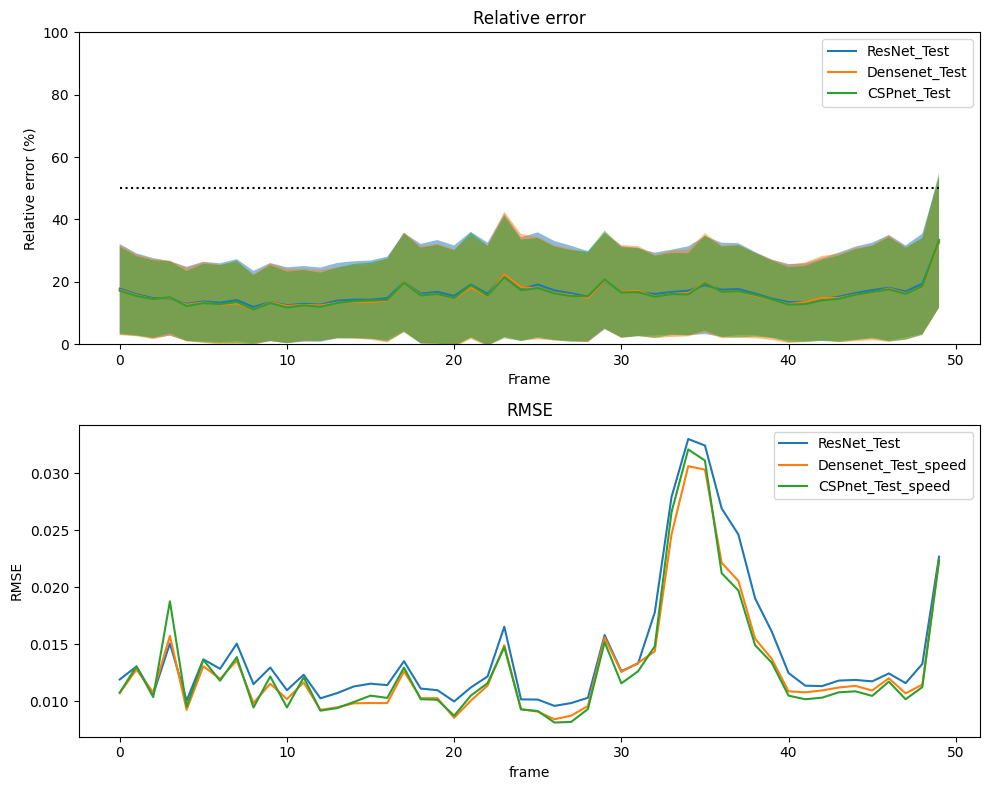

In [23]:
model_names = ['20230301-1654', '20230301-1704'] # resnet: Temporal4DFlowNet_20230301-1641 #
set_names = [set_name, set_name]
labels = [f'Densenet_{set_names[0]}', f'CSPnet_{set_names[1]}']#[f'{model_names[i][-4::]}_{set_names[i]}' for i in range len(model_names)]
frames = len(rel_error)

vel_colnames = ["u", "v", "w"]
plt.subplot(2, 1, 1)
plt.title("Relative error")
plt.plot(rel_error, label = f'ResNet_{set_name}')
# plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
points_in_mask = np.where(gt['mask'] !=0)

reshaped_error = np.tanh(error_pointwise[:, points_in_mask[0], points_in_mask[1], points_in_mask[2]].reshape(frames, -1))
max_error = np.max(reshaped_error, axis=1)*100

sd_error = np.std(reshaped_error, axis = 1)*100
error = np.random.normal(0, sd_error, size=len(rel_error))
plt.fill_between(range(len(rel_error)), rel_error-sd_error, rel_error+sd_error, alpha = 0.5)


plt.subplot(2, 1, 2)
plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = f'ResNet_{set_name}')
plt.ylabel('RMSE')
plt.xlabel('frame')
plt.title('RMSE')

for m_name, s_name, label in zip(model_names, set_names, labels):
    _, _, prediction, _, _ = load_data(m_name, s_name, data_model, step)
    rel_err = calculate_relative_error_normalized(prediction["u"], prediction["v"], prediction["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
    pointwise_error, _  = calculate_pointwise_error(prediction["u"], prediction["v"], prediction["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
    reshaped_error = np.tanh(pointwise_error[:, points_in_mask[0], points_in_mask[1], points_in_mask[2]].reshape(frames, -1))
    max_error = np.max(reshaped_error, axis=1)*100

    sd_error = np.std(reshaped_error, axis = 1)*100
    error = np.random.normal(0, sd_error, size=len(rel_error))
    # if m_name != '20230301-1704':
    plt.subplot(2, 1, 1)
    plt.fill_between(range(len(rel_error)), rel_err-sd_error, rel_err+sd_error, alpha = 0.5)
    plt.plot(rel_err, label=label)
    plt.legend()
    # mean_speed = calculate_mean_speed(prediction["u"], prediction["v"], prediction["w"],gt["mask"])

    plt.subplot(2, 1, 2)
    plt.plot(calculate_rmse(prediction['speed'], gt['speed'], gt['mask']), label = f'{label}_speed')

plt.legend()
plt.tight_layout()
plt.show()